In [ ]:
%pylab inline

In [2]:
import pandas as pd
import numpy as np
import scipy as spy
import os
import copy
import pickle
import itertools

from glob import glob

import seaborn as sns
blues = np.array(sns.light_palette("blue"))[[-4,-1]]
purples = np.array(sns.light_palette("purple"))[[-4,-1]]

import matplotlib.patches as mpatches
from collections import Counter, defaultdict
from itertools import combinations

from tqdm import tqdm_notebook

import collections, functools, operator 


from multiprocessing import Pool
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates

# Pop

In [3]:
# Read data italian population
pop = pd.read_csv("./data/pop.csv", sep=",", index_col=None)
N = pop.Value.sum()
N

59394207

# Load Data

In [4]:
#Read covid dataset
covidITA = pd.read_csv("./data/dpc-covid19-ita-andamento-nazionale.csv")
covidITA.index = pd.to_datetime(pd.to_datetime(covidITA["data"]).dt.strftime('%Y-%m-%d'))
#display(covidITA.columns)
covidITA = covidITA[["totale_positivi", "nuovi_positivi", 'ricoverati_con_sintomi', 'terapia_intensiva', 'totale_ospedalizzati', "deceduti", "dimessi_guariti"]]
covidITA.index.name="date"

In [5]:
#setting start date on 1 sept
covidITA = covidITA.loc["2020-09-01":]

In [6]:
#convert to time granularity one weeek
covidITAW = pd.concat(
    [covidITA.totale_positivi.resample("7D").mean(),
     covidITA.ricoverati_con_sintomi.resample("7D").mean(),
     covidITA.terapia_intensiva.resample("7D").mean(),
     covidITA.totale_ospedalizzati.resample("7D").mean(),
     covidITA.dimessi_guariti.resample("7D").mean(),
     covidITA.deceduti.resample("7D").mean()], axis=1)

startIndex = 0
endTime = 29

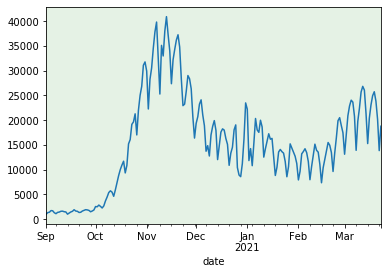

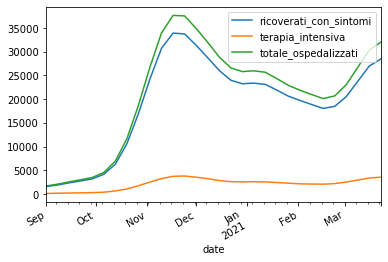

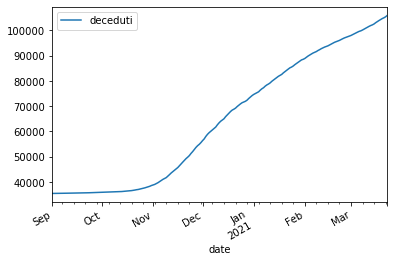

In [7]:
#plot data
startDate = covidITAW.index[startIndex]
flexDate = covidITAW.index[startIndex]
endDate = covidITAW.index[startIndex+endTime]

covidITA.nuovi_positivi.plot()
plt.gca().axvspan(startDate, flexDate, alpha=0.1, color='r')
plt.gca().axvspan(flexDate, endDate, alpha=0.1, color='g')

covidITAW[['ricoverati_con_sintomi', 'terapia_intensiva', 'totale_ospedalizzati']].plot()
plt.gcf().autofmt_xdate()

covidITA[["deceduti"]].plot()
plt.gcf().autofmt_xdate()

# Fit data

In [13]:
def step(SIHDR, par):
    '''
    run one step of the epidemic model 
    '''
    N = 59_394_207
    S,I,H,D,R,beta = SIHDR
    betaL, betaH, gamma, gamma2, alpha, lambd, K, I0, H0, thH = par

    beta1 = betaL + (betaH-betaL) * (1+np.tanh(K*(thH-H)))/2 
    
    S1 = S - beta*I*S/N
    I1 = I - gamma*I - alpha*I + beta*I/N*S
    H1 = H + alpha*I - gamma2*H - lambd*H
    D1 = D + lambd*H
    R1 = R + gamma*I + gamma2*H

    return S1,I1,H1,D1,R1,beta1


class ModelSIHDR():
    def __init__(self, covidITA, **kwargs):
        self.startIndex = startIndex
        self.endTime = endTime
        self.N = 59_394_207
            
        self.timeS = np.arange(0, self.endTime+1, 1)
        self.dates = covidITA.index[startIndex:startIndex+endTime+1]
        self.startDate = covidITA.index[startIndex]
        self.endDate = covidITA.index[startIndex+endTime]
        
        # time-series for fit
        self.covidH = covidITA.totale_ospedalizzati[self.startDate:self.endDate].values
        self.covidD = covidITA.deceduti[self.startDate:self.endDate].values
        
        # initial condition from data
        self.H0 = covidITA.totale_ospedalizzati[self.startDate]
        self.D0 = covidITA.deceduti[self.startDate]    
        self.I0 = covidITA.totale_positivi[self.startDate]    
 
    def predict(self, par):
        betaL, betaH, gamma, gamma2, alpha, lambd, K, I0, S0, thH = par
        gamma, gamma2, alpha, lambd = 1/gamma, 1/gamma2, 1/alpha, 1/lambd
        par = betaL, betaH, gamma, gamma2, alpha, lambd, K, I0, S0, thH
        
        #set initial condition
        _I0 = I0
        _S0 = (self.N - self.H0 - self.D0 - _I0) * S0
        _R0 = self.N - _S0 - _I0 - self.H0 - self.D0
        
        _beta0 = betaL + (betaH-betaL) * (1+np.tanh(K*(thH-self.H0)))/2 
        y = [_S0, _I0, self.H0, self.D0, _R0, _beta0]
    
        #iterate steps
        sol = np.empty((len(self.timeS), 6))
        for i in self.timeS:
            sol[i] = y
            y = step(y, par)
        return sol

In [14]:
# read initial condition
m = ModelSIHDR(covidITAW)
m.I0,m.H0,m.D0

(29978.571428571428, 1686.2857142857142, 35520.0)

In [15]:
def fToMin(x, getRes=False, getPar=False):   
    betaL, betaH, alpha, lambd, K, I0, thH = x

    S0 = 1 #fixed number of suceptible population
    gamma = 14.32/7 #fixed number recovery from literature 14.32 days
        
    gamma2 = lambd * 1/(1-0.25)
    lambd  = lambd * 1/(0.25)
    
    par = betaL, betaH, gamma, gamma2, alpha, lambd, K, I0, S0, thH
    if getPar: 
        return {"betaL":betaL, "betaH":betaH, "gamma":gamma, "gamma2":gamma2, "alpha":alpha, "lambd":lambd, "K":K, "I0":I0, "S0":S0, "thH":thH}
    
    pred = m.predict(par)
    if getRes:
        hospital = pd.DataFrame(np.c_[pred[:, 2], m.covidH], columns=["H Predicted", "H Data"], index=m.dates)
        deaths = pd.DataFrame(np.c_[pred[:, 3], m.covidD], columns=["D Predicted", "D Data"], index=m.dates)
        betas = pd.DataFrame(pred[:, 5], columns=["Beta"], index=m.dates)
        return hospital, deaths, betas

    return mean_squared_error(np.c_[m.covidH, m.covidD], np.c_[pred[:, 2],pred[:, 3]])

In [16]:
bounds = (
    (0.2, 1.5),      #betaL
    (0.2, 1.5),      #betaH
    (1, 150),        #alpha
    (0.2, 5),        #lambda
    (0.0001, 0.001), #K
    (m.I0, m.I0*10), #I0
    (10_000, 40_000) #thH
)

In [20]:



parCalibration = pickle.load(open("./data/resCalibration/calibrationFinalW001v2", "rb" ))  
parCalibration

{'betaL': 0.45686001080419,
 'betaH': 0.7991490461149616,
 'gamma': 2.045714285714286,
 'gamma2': 2.7391361785112527,
 'alpha': 35.770162994195054,
 'lambd': 8.217408535533758,
 'K': 0.001,
 'I0': 65861.61906762236,
 'S0': 1,
 'thH': 20320.100749070727,
 'H0': 1686.2857142857142,
 'D0': 35520.0}

/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


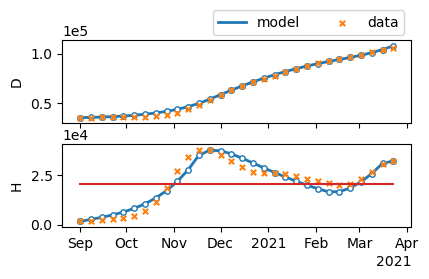

In [19]:
#plot fitting results

#prepare data
H, D, betas = fToMin(opt.x, getRes=True)
par = fToMin(opt.x, getPar=True)
H.columns = ["model", "data"]
D.columns = ["model", "data"]

#plot
nRow=2
hspace=0.25
hRow=1.1

fig, ax = plt.subplots(nRow, sharex=True, figsize=(4.5,nRow*hRow + ((nRow-1)*hspace*hRow)), dpi=100)
plt.subplots_adjust(hspace=hspace)

ax[0].plot(D.index, D.model, zorder=1, linewidth=2, label="model")
ax[0].scatter(D.index, D.model, marker="o", s=15, facecolors='w', edgecolors='C0', zorder=2)

ax[0].scatter(D.index, D.data, marker="x", s=15, color='C1', zorder=2, label="data")
ax[0].set_ylabel("D")

ax[1].plot(H.index, H.model, zorder=1, linewidth=2, label="model")
ax[1].scatter(H.index, H.model, marker="o", s=15, facecolors='w', edgecolors='C0', zorder=2)

ax[1].scatter(H.index, H.data, marker="x", s=15, color='C1', zorder=2, label="data")
ax[1].plot(H.index, [par["thH"]]*len(H.index), c="C3", label=r"$\bar H$")
ax[1].set_ylabel("H")

ax[0].legend(loc='upper right', bbox_to_anchor=(1.0, 1.45), ncol=2, fancybox=True, shadow=False)
for _ax in ax: _ax.yaxis.set_label_coords(-0.11, 0.5)
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    
    
locator = mdates.AutoDateLocator(minticks=3, maxticks=11)
formatter = mdates.ConciseDateFormatter(locator)
ax[-1].xaxis.set_major_locator(locator)
ax[-1].xaxis.set_major_formatter(formatter)

plt.savefig("./calibration.pdf", pad_inches=0.5, bbox_inches="tight")

In [23]:
#save results
par["H0"] = m.H0
par["D0"] = m.D0
pickle.dump(par, open("./data/resCalibration/calibrationFinalW001v2", "wb" )) 